In [0]:
from pyspark.sql.functions import *
from pyspark.ml.feature import *
from pyspark.ml.classification import *
from pyspark.ml import *
from pyspark.ml.evaluation import *
from pyspark.ml.tuning import *
from pyspark.mllib.evaluation import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, roc_curve, auc, RocCurveDisplay

## Fine-tuned Random Forest Model

In [0]:
meme_clean_sentiment = spark.read.parquet("/FileStore/meme_clean_sentiment")
class1 = meme_clean_sentiment.select("stock","text").groupBy("stock").count().orderBy(col("stock"))
class1 = class1.withColumn('class_weight', meme_clean_sentiment.count()/(4*col('count')))

In [0]:
stock_sub = meme_clean_sentiment.select("stock","text").join(class1.select('stock','class_weight'), 
                                                             on=['stock'], how='left')

In [0]:
# Regex tokenizer
regexTokenizer = RegexTokenizer(inputCol="text", outputCol="words", pattern="\\W")
# BOW count
countVectors = CountVectorizer(inputCol="words", outputCol="features", vocabSize=10000, minDF=5)
# String Indexer
stringIndex = StringIndexer(inputCol = "stock", outputCol = "label")
# One-Hot-Encoder on Labels
encoder = OneHotEncoder(inputCol = 'label', outputCol = 'categoryVec')
# Normalizing
normalizer = Normalizer(inputCol = 'features', outputCol = 'features_norm', p=1.0)
# Apply pipline
pipeline_log = Pipeline(stages=[regexTokenizer,
                                countVectors,
                                normalizer,
                                stringIndex,
                                encoder])
# Fit the pipeline
stock_classify = pipeline_log.fit(stock_sub).transform(stock_sub)

In [0]:
# Partition training & testing set proportionally
train1 = stock_classify.sampleBy("label", fractions={0: 0.7, 1: 0.7, 2: 0.7, 3:0.7}, seed=42)
test1 = stock_classify.subtract(train1)

In [0]:
rf = RandomForestClassifier(numTrees = 100,
                            maxDepth = 5,
                            maxBins = 24,
                            weightCol='class_weight')

paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [int(x) for x in np.linspace(start = 10, stop = 50, num = 3)]) \
    .addGrid(rf.maxDepth, [int(x) for x in np.linspace(start = 5, stop = 25, num = 3)]) \
    .build()

# Set evaluator for CrossValidator
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")

cv = CrossValidator(estimator=rf, \
                    estimatorParamMaps=paramGrid, \
                    evaluator=evaluator, \
                    numFolds=5)

CVmodel2 = cv.fit(train1)

## Save Fine-tuned model

In [0]:
basePath = "/tmp/mllib-model"
CVmodel2.write().overwrite().save(basePath + "/model")
CV_RF = CrossValidatorModel.load(basePath + "/model")

## Load comments dataset

In [0]:
meme_comm_clean = spark.read.parquet("/FileStore/meme_stock_comm_clean")
meme_comm_clean = meme_comm_clean.sample(withReplacement=False, fraction=0.013, seed=666)
meme_comm_clean = meme_comm_clean.withColumn('stock', when(col('gme')==True, 'GME')
                                   .when(col('amc')==True, 'AMC')
                                   .when(col('btc')==True, 'BTC')
                                   .when(col('eth')==True, 'ETH')
                                   .otherwise('other')
                                  )

In [0]:
meme_comm_clean = meme_comm_clean.filter(col('stock')!='other').select('body','stock')
meme_comm_clean = meme_comm_clean.withColumnRenamed('body','text')

In [0]:
class2 = meme_comm_clean.select("stock","text").groupBy("stock").count().orderBy(col("stock"))
class2 = class2.withColumn('class_weight', meme_comm_clean.count()/(4*col('count')))

In [0]:
comm_sub = meme_comm_clean.select("stock","text").join(class2.select('stock','class_weight'), 
                                                             on=['stock'], how='left')

In [0]:
comm_classify = pipeline_log.fit(comm_sub).transform(comm_sub)
comm_classify.show(10)

+-----+--------------------+------------------+--------------------+--------------------+--------------------+-----+-----------+
|stock|                text|      class_weight|               words|            features|       features_norm|label|categoryVec|
+-----+--------------------+------------------+--------------------+--------------------+--------------------+-----+-----------+
|  ETH|APES STRONG TOGET...|2.4172248489624377|[apes, strong, to...|(10000,[0,1,127,2...|(10000,[0,1,127,2...|  3.0|  (3,[],[])|
|  ETH|They don’t want y...|2.4172248489624377|[they, don, t, wa...|(10000,[0,1,7,8,1...|(10000,[0,1,7,8,1...|  3.0|  (3,[],[])|
|  ETH|You would think c...|2.4172248489624377|[you, would, thin...|(10000,[7,19,55,7...|(10000,[7,19,55,7...|  3.0|  (3,[],[])|
|  ETH|But isn't it kind...|2.4172248489624377|[but, isn, t, it,...|(10000,[1,2,3,5,8...|(10000,[1,2,3,5,8...|  3.0|  (3,[],[])|
|  ETH|LISTEN TO ME. DO ...|2.4172248489624377|[listen, to, me, ...|(10000,[0,1,2,3,4...|(10000,[

In [0]:
CV_pred2 = CVmodel2.transform(comm_classify)

## Model evaluation

In [0]:
def model_evaluate(predictions):
    eval_accuracy = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", 
                                                      metricName="accuracy")
    eval_f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", 
                                                metricName="f1")
    eval_auc = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol='prediction', 
                                             metricName='areaUnderROC')
    
    accuracy = eval_accuracy.evaluate(predictions)
    f1score = eval_f1.evaluate(predictions)
    auc = eval_auc.evaluate(predictions)
    
    return {'accuracy':accuracy, 
            'f1_score':f1score,
            'auc':auc}

In [0]:
model_evaluate(CV_pred2)

Out[52]: {'accuracy': 0.28689604585772693,
 'f1_score': 0.1875388147974087,
 'auc': 0.49974135004159276}

<Figure size 720x720 with 0 Axes>

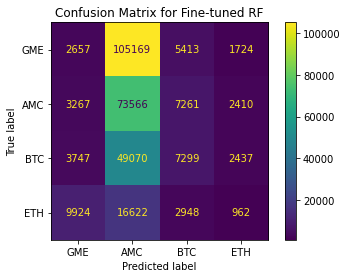

In [0]:
# CM for the best model
y_true = CV_pred2.select('label').collect()
y_pred = CV_pred2.select('prediction').collect()
CM = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(CM, display_labels=['GME','AMC','BTC','ETH'])
plt.figure(figsize = (10,10))
disp.plot()
plt.title("Confusion Matrix for Fine-tuned RF")
plt.show()